In [82]:

#@title Tensorflow Probability Installation (make sure to run this cell)  { display-mode: "form" }
TFP_Installation = "Stable TFP" #@param ["Most Recent TFP", "Stable TFP", "Stable TFP-GPU", "Most Recent TFP-GPU", "TFP Already Installed"]

if TFP_Installation == "Most Recent TFP":
    !pip3 install -q tfp-nightly
    print("Most recent TFP version installed")
elif TFP_Installation == "Stable TFP":
    !pip3 install -q --upgrade tensorflow-probability
    print("Up-to-date, stable  TFP version installed")
elif TFP_Installation == "Stable TFP-GPU":
    !pip3 install -q --upgrade tensorflow-probability-gpu
    print("Up-to-date, stable TFP-GPU version installed")
    print("(make sure GPU is properly configured)")
elif TFP_Installation == "Most Recent TFP-GPU":
    !pip3 install -q tfp-nightly-gpu
    print("Most recent TFP-GPU version installed")
    print("(make sure GPU is properly configured)")
elif TFP_Installation == "TFP Already Installed":
    print("TFP already instaled in this environment")
    pass
else:
    print("Installation Error: Please select a viable TFP installation option.")
!pip3 install -q corner seaborn

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Up-to-date, stable  TFP version installed
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [83]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import math
import matplotlib 
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import pandas as pd
import matplotlib.axes as axes;
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)
font = {'family' : 'Dejavu Sans','size'   : 20}
matplotlib.rc('font', **font)

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    reset_session()

import tensorflow_probability as tfp
tfd = tfp.distributions

def default_session_options(enable_gpu_ram_resizing=True,
                            enable_xla=False):
  """Creates default options for Graph-mode session."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple
    # colabs to your GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  if enable_xla:
    # Enable on XLA. https://www.tensorflow.org/performance/xla/.
    config.graph_options.optimizer_options.global_jit_level = (
        tf.OptimizerOptions.ON_1)
  return config

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def reset_session(options=None):
  """Creates a new global, interactive session in Graph-mode."""
  if tf.executing_eagerly():
    return
  global sess
  try:
    tf.reset_default_graph()
    sess.close()
  except:
    pass
  if options is None:
    options = default_session_options()
  sess = tf.InteractiveSession(config=options)


def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)
  
def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


class _TFColor(object):
  """Enum of colors used in TF docs."""
  red = '#F15854'
  blue = '#5DA5DA'
  orange = '#FAA43A'
  green = '#60BD68'
  pink = '#F17CB0'
  brown = '#B2912F'
  purple = '#B276B2'
  yellow = '#DECF3F'
  gray = '#4D4D4D'
  magenta =  '#8B008B'
  def __getitem__(self, i):
    return [
        self.red,
        self.orange,
        self.green,
        self.blue,
        self.pink,
        self.brown,
        self.purple,
        self.yellow,
        self.gray,
        self.magenta
    ][i % 10]
TFColor = _TFColor()

In [84]:
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)

font = {'family' : 'Dejavu Sans','size'   : 20}
matplotlib.rc('font', **font)

## Crack Propagation Model

Predicting the life of a component that is prone to cracking is an age-old problem that has been studied ad-nauseam by the fracture mechanics community. [Crack propagation models](https://en.wikipedia.org/wiki/Fracture_mechanics) are at the core of Prognostics and Health Management (PHM) solutions for engineering systems and the aptly titled book [Prognostics and Health Management of Engineering Systems: An Introduction](https://books.google.com.sg/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics+and+health+management+of+engineering+systems&pg=PR3&redir_esc=y#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false) provides a great example of how real world data can be used to calibrate engineering models. This data set, was used, in the blog on [BHGE's Industrial AI](https://medium.com/tensorflow/industrial-ai-bhges-physics-based-probabilistic-deep-learning-using-tensorflow-probability-5f215c791863), to illustrate the the developement of a "Hybrid model" that combined probabilistic learning with engineering domain knowledge.

The phenomenon of fatigue crack propagation can be modeled with the Paris law. Paris law relates the rate of crack growth $\left(da/dN\right)$ to the stress intensity factor  $\left(\Delta K = \Delta\sigma\sqrt{\pi a}\right)$ through the equation below:

$\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m$

Where $a$ is the crack length, $N$ is the number of loading cycles, $\sigma$ is the stress, and $C, m$ are material properties.
Integrating the Paris law for a specific geometry and loading configuration, we arrive at the analytical formulation for the size of a crack as a function of the loading cycle as shown below:

$a(N) = \left[ N  C \left(1-\frac{m}{2}\right) \left(\Delta\sigma\sqrt{\pi}\right)^m + a_0^{1-\frac{m}{2}}\right]^\frac{2}{2-m}$

where $a_0$ is the initial crack length.
The parameters $C$ and $m$ need to be calibrated for each application with crack length $(a)$ vs loading cycles $(N)$ data. Such data is usually obtained during maintenance and inspections of engineering systems. In this example, we will use the sample dataset from the [PHM book by Kim, An and Choi](https://books.google.com.sg/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics+and+health+management+of+engineering+systems&pg=PR3&redir_esc=y#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false). A sample code for the crack propagation model is provided below

In [85]:
def predict_crack(cycles, logC, m, init_crack_len, dsig):

    C = np.exp(logC)
    stress_const = dsig * math.sqrt(math.pi)

    num_meas = cycles.size
    init_crack_len = init_crack_len

    if num_meas == 1:
        crack_len = calc_cracklen(cycles, C, m, init_crack_len, stress_const)
    else:
        diff_cycles = np.diff(cycles)
        crack_len = np.zeros(num_meas)
        crack_len[0] = init_crack_len
        for i in range(1, num_meas):
            crack_val = calc_cracklen(diff_cycles[i-1], C, m, crack_len[i-1], stress_const)
            crack_len[i] = crack_val
    crack_len = crack_len

    return crack_len


def calc_cracklen(cycles, C, m, init_crack_len, stress):
    try:
        crack_val = math.pow(cycles * C * (1 - m / 2.0) * math.pow(stress, m) +
                             math.pow(init_crack_len, 1 - m / 2.0), 2.0 / (2.0 - m))
    except:
        crack_val = init_crack_len

    return crack_val


## Problem Description

In the blog on [BHGE's Industrial AI](https://medium.com/tensorflow/industrial-ai-bhges-physics-based-probabilistic-deep-learning-using-tensorflow-probability-5f215c791863), a hybrid prognostic model was built using the entire data set. We will consider a different scenario here. An initial model is built based on knowledge of physics and known material properties. When this model was used to predict crack size, the model predictions were reasonably accurate for an initial period, but significant discrepancies were observed between predictions and observations over time. Such a scenario is very common in the industrial domain when material properties or design of a component (for e.g., blade of gas turbine) are changed. In such cases, as no field data is available, maodels are built with simulated data or limited experimental results. These models need to be validated and refined when data from the field becomes available. We will illustrate an approach that leverages the newly available information to improve the initial model? 

## A brief discussion on the Data

Though the data is from a textbook example, it exhibits certain characteristics that are commonly observed in field data:

1. Noise in Data
While the overall trend in crack size with respect to cycles is increasing, it's not strictly monotonic. At certain instances, the observed crack is less than what was measured at the previous instant. This may very well be due to measurement error, a common feature of all field data. In other words, the data is noisy.

2. Small Sample Size
The data set consists of merely 16 data points, which is inadequate to build any meaningful data-driven model. Hence, it is critical to leverage the understanding of the physics of crack propagation in order to build a useful model.

To complicate things a bit further, in real-world applications, it may not even be possible to obtain data of progressive degradation from the same component or system. The data available for modeling is usually from different assets at various stages of degradation. Therefore, hybrid modeling approaches are critical for industrial analytics.

To illustrate an approach for updating models, the data set is divided into three parts:
1. Initial data set - The initial model predictions are reasonable accurate in this data set. It consists of the first six data points [cycles 0 to 500].
2. Update data set - The initial model predictions are not accurate in this data set. This data set, as the name suggests, is used to update the initial model. It consists of the next five data points [cycles 600 to 1000].
3. Test data set - This data set is used to validate the predictions of the updated model. It consists of the last five data points [cycles 1100 to 1500]

The initial model parameters are: $logC = -22.135$ and  $m = 3.765$
The model predictions, for the initial data set,init are displayed below:

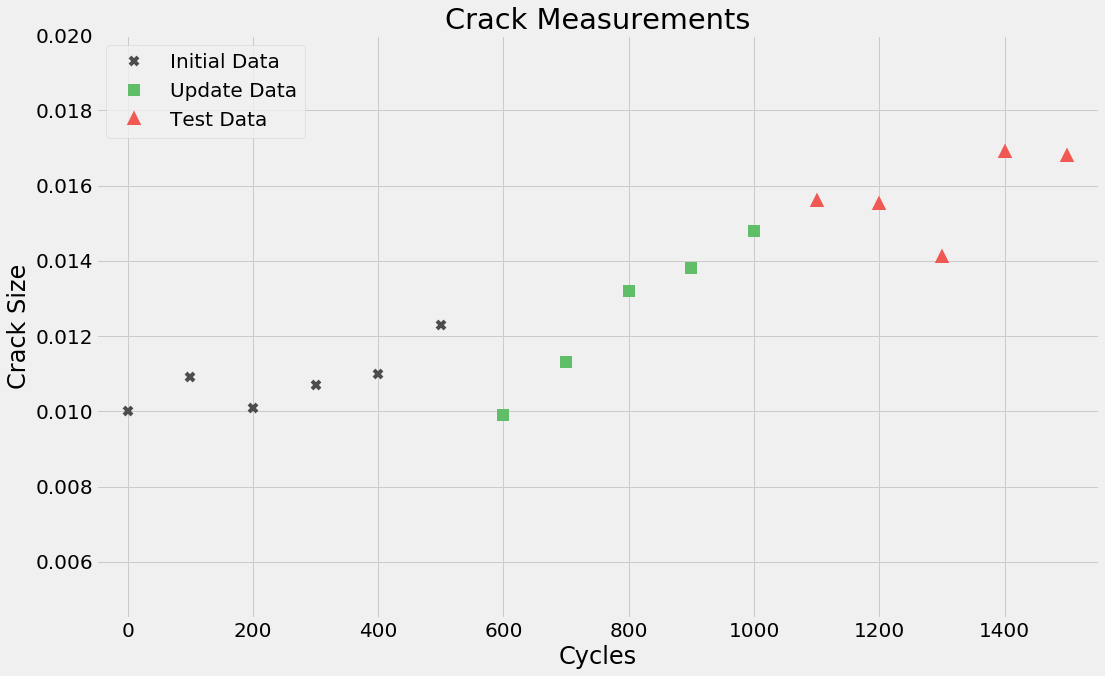

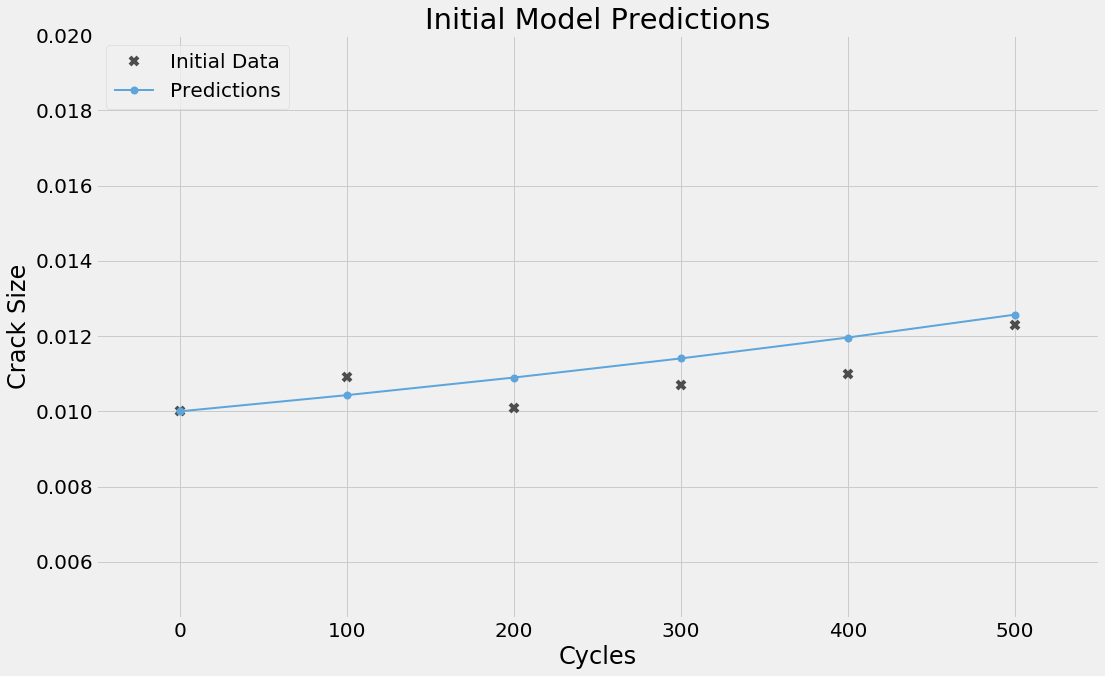

In [90]:
# true values of the parameters
t = tf.range(0.,1600., 100) #cycles
y = tf.constant([0.0100,0.0109,0.0101,0.0107,0.0110,0.0123,0.0099,0.0113, 
   0.0132,0.0138,0.0148,0.0156,0.0155,0.0141,0.0169,0.0168]) # measured crack size data

# The evaluate() function, defined at the top of this notebook, runs `sess.run()` 
# in graph mode and allows code to be executed eagerly when Eager mode is enabled
[ cycles, crack_meas] = evaluate([t, y])
diff_cycles = np.diff(cycles)
num_meas = len(crack_meas)

dsig = 75.0                    # Stress parameter
# Initial Model Paramters
logC = -22.135
m = 3.765

init_indx = 6           # Last index of the training data set. 
updt_indx = 11           # Last index of the update data set.
test_indx = num_meas     # Last index of the test data set

# Initial Model Prediction
crack_pred_init = np.zeros((num_meas, 1))
crack_pred_init[0] = crack_meas[0]
crack_pred_init = predict_crack(cycles, logC, m, crack_pred_init[0], dsig)

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(cycles[0:init_indx], crack_meas[0:init_indx], 'x', markersize=8, markeredgewidth=4, color=TFColor[8])
axs.plot(cycles[init_indx:updt_indx], crack_meas[init_indx:updt_indx], 's', markersize=8, markeredgewidth=4, color=TFColor[2])
axs.plot(cycles[updt_indx:num_meas], crack_meas[updt_indx:num_meas], '^', markersize=8, markeredgewidth=4, color=TFColor[0])
axs.set_xlabel('Cycles')
axs.set_ylabel('Crack Size')
axs.set_xlim([-50, 1550])
axs.set_ylim([0.0045, 0.02])
axs.grid(True)
plt.legend(['Initial Data', 'Update Data', "Test Data"], loc='upper left')
plt.title('Crack Measurements')
plt.savefig('Measured_Data.png')

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(cycles[0:init_indx], crack_meas[0:init_indx], 'x', markersize=8, markeredgewidth=4,
         color=TFColor[8])
axs.plot(cycles[0:init_indx], crack_pred_init[0:init_indx], color=TFColor[3], marker='.', linestyle='-', 
         markersize=8,  markeredgewidth=4, linewidth=2)
plt.legend(['Initial Data', 'Predictions'], loc='upper left')
axs.set_xlabel('Cycles')
axs.set_ylabel('Crack Size')
axs.set_xlim([-50, 550])
axs.set_ylim([0.0045, 0.02])
axs.grid(True)
plt.title('Initial Model Predictions')
plt.savefig('Init_Model_Init_Data.png')

The model predictions are fairly accurate with respect to the measured values. The mean squared error (MSE) for the initial data set is found to be:

$ MSE^{i} = 3.93e-7 $

The model's prediction of crack sizes over the time-period corresponding to the update data set is provided below.

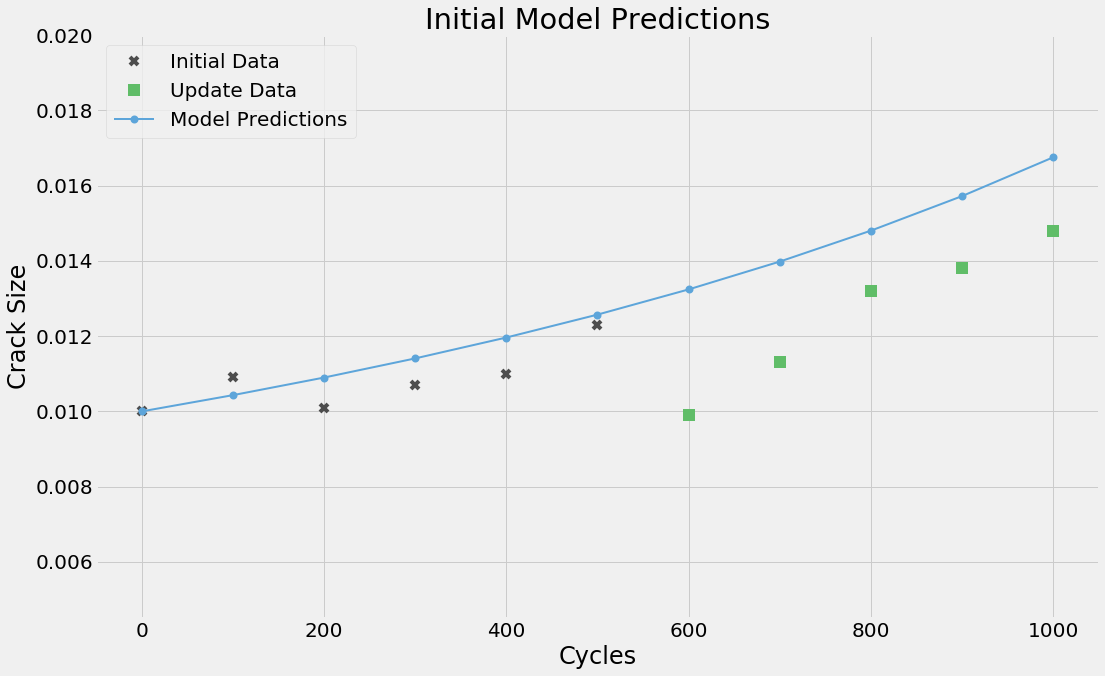

In [91]:
# Initial Model Predictions for the initial and update data sets
fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(cycles[0:init_indx], crack_meas[0:init_indx], 'x', markersize=8, markeredgewidth=4, color=TFColor[8])
axs.plot(cycles[init_indx:updt_indx], crack_meas[init_indx:updt_indx], 's', markersize=8, markeredgewidth=4, color=TFColor[2])
axs.plot(cycles[0:updt_indx], crack_pred_init[0:updt_indx], color=TFColor[3], marker='.', linestyle='-', 
         markersize=8,  markeredgewidth=4, linewidth=2)
plt.legend(['Initial Data', 'Update Data', 'Model Predictions'], loc='upper left')
axs.set_xlabel('Cycles')
axs.set_ylabel('Crack Size')
axs.set_xlim([-50, 1050])
axs.set_ylim([0.0045, 0.02])
axs.grid(True)
plt.title('Initial Model Predictions')
plt.savefig('Init_Model_Updt_Data.png')

It can be observed that the initial model's predictions are no longer accurate. The MSE for the update data is found to be: 

$ MSE^{u} = 5.67e-6$

$MSE^{u}$ is about 14 times larger than $MSE^{i}$. Further, there's a clear divergence between model predictions and the observed crack size in the update data set, as cycles increase. Therefore, the model needs to be updated/refined to make it more accurate.

## Methodology

One of the techniques that has been used for model updating is the [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter) (KF) and its variants, namely the [Extended Kalman Filter ](https://en.wikipedia.org/wiki/Extended_Kalman_filter)(EKF) and the [Unscented Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter) (UKF). 

The following assumptions are made in the case of KF:
1. The process model is linear
2. The measurement model is linear
3. The initial state is Gaussian

The EKF and the UKF allow for the relaxation of the first two assumptions. A central operation performed in the Kalman Filter is the propagation of a Gaussian random variable (GRV) through the system dynamics. In the EKF, the state distribution is approximated by a GRV, which is then propagated analytically through the first-order linearization of the nonlinear system. This can introduce large errors in the true posterior mean and covariance of the transformed GRV, which may lead to sub-optimal performance and sometimes divergence of the filter. The UKF addresses this problem by using a deterministic sampling approach. The state distribution is again approximated by a GRV, but is now represented using a minimal set of carefully chosen sample points. These sample points completely capture the true mean and covariance of the GRV, and when propagated through the true nonlinear system, captures the posterior mean and covariance accurately to the 3rd order (Taylor series expansion) for any nonlinearity. The EKF in contrast, only achieves first-order accuracy. Remarkably, the computational complexity of the UKF is the same order as that of the EKF. 

We will utilize the UKF to update the initial crack propagation model. To do so, the problem needs to be cast in the UKF framework. The parameters that need to be updated, C and m, are considered as the "states" of the the UKF. By convention, the states are denoted by $ \mathbf{x} $. The states are modeled as a random walk process. The crack propagation model, described earlier, is the measurement equation. Together, the process and measurement models of the UKF are represented as:

$\mathbf{x}_{k} = \mathbf{x}_{k-1} + \mathbf{w}_{k}$

$\mathbf{a}_{k} = \mathbf{h}\left(\mathbf{x}_{k}, \mathbf{u}_{k}\right) + \mathbf{v}_{k}$

where, $\mathbf{a}$ is the crack size and $\mathbf{u}$ is the number of cycles. $\mathbf{h}$ represents the crack propagation model. $\mathbf{w}$ is the process noise and $\mathbf{v}$ is the measurement noise. These are assumed to be zero-mean, Gaussian and [white](https://en.wikipedia.org/wiki/White_noise).

The key steps in the UKF based model update methodology are summarized below:
1. Initialize the state vector and its uncertainty (covariance)
2. Generate sigma points based on the state
3. Propagate sigma points and compute predicted mean and covariance of the state.
4. Compute sigma points based on predicted mean and covariance
5. Calculate output for each sigma point
6. Calculate the predicted output as the weighted sum of individual outputs from step 6.
7. Calculate the uncertainty (covariance) of the predicted output
8. Compute the cross covariance between the predicted state and the predicted output.
9. Compute the innovation as the difference between the measured output and the predicted output.
10. Compute the filter gain using the cross covariance and output covariance
11. Update the state vector and its covariance.
12. Repeat steps 2 to 11 for all the data points used for the model updating.

A curious reader can learn about the math behind the UKF, [here](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter).

## UKF Implementation
The code, implementing the various steps of the UKF algorithm, is provided below.

#### Initialization

In [68]:
import warnings

warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)
    

# Assign Initial State and covariance
x_init = np.array([logC, m])
cov_init = np.matrix(([1e-3, 0.0], [0.0, 1e-3]))

# Set Process and Measurement Covariances
Q = tf.constant(([1e-3, 0], [0, 1e-3]), dtype=tf.float64)
R = tf.constant(0.1e-6, dtype=tf.float64)

num_st = len(x_init)          # Number of states of the UKF
x_init.shape = (num_st, 1)

#### Set Filter parameters

In [69]:
# UKF Parameters
kappa = tf.constant(0.0, dtype=tf.float64)
alpha = tf.constant(1.0, dtype=tf.float64)
beta = tf.constant(2.0, dtype=tf.float64)

# UKF weights for mean and covariance
theta = (alpha ** 2) * (num_st + kappa) - num_st
w0_mean = theta / (num_st + theta)
w0_cov = w0_mean * (1 - (alpha ** 2) + beta)
w_i = 0.5 / (num_st + theta)

In [70]:
# Variables for control flow
temp_var = tf.Variable(np.zeros((num_st, num_st)), dtype=tf.float64)
temp_var2 = tf.Variable(np.zeros((num_st, 2*num_st+1)), dtype=tf.float64)
temp_var3 = tf.Variable(np.zeros((1, 2*num_st+1)), dtype=tf.float64)
temp_var4 = tf.Variable(np.zeros((num_st, num_st)), dtype=tf.float64)

# Placeholders
x_prev = tf.placeholder(tf.float64)
cov_prev = tf.placeholder(tf.float64)
sigma_points = tf.placeholder(tf.float64)
zhat_mat = tf.placeholder(tf.float64)
out_cov = tf.placeholder(tf.float64)
cross_cov = tf.placeholder(tf.float64)
pred_out = tf.placeholder(tf.float64)
meas_out = tf.placeholder(tf.float64)
k_gain = tf.placeholder(tf.float64)

#### Compute square-root of a square matrix

In [71]:
# Compute square-root of the covariance matrix and multiply it by the UKF scaling factor
assign_sqrt = tf.assign(temp_var, cov_prev)
with tf.control_dependencies([assign_sqrt]):
    [eigval, eigvec] = tf.linalg.eigh(temp_var)
    s_tf = tf.sqrt(eigval)
    S_tf = tf.diag(s_tf)
    sqrt_cov = tf.matmul(tf.matmul(eigvec, S_tf), tf.matrix_inverse(eigvec))
    
    eta = tf.sqrt((alpha ** 2) * (num_st + kappa))                # UKF scaling factor
    temp = tf.scalar_mul(eta, sqrt_cov)

#### Compute predicted mean and covariance

In [72]:
# Compute predicted mean and covariance
assign_prop = tf.assign(temp_var2, sigma_points)
with tf.control_dependencies([assign_prop]):
    # Predict Mean
    x_minus = w0_mean * temp_var2[:, 0] + w_i * tf.reduce_sum(temp_var2[:, 1:2 * num_st + 1], axis=1)
    x_minus = tf.reshape(x_minus, (num_st, 1))
    
    temp1 = tf.reshape(temp_var2[:, 0], (num_st, 1))

    # Predict Covariance
    cov_minus = (temp1 - x_minus) * tf.transpose((temp1 - x_minus))
    for i in range(1, 2 * num_st + 1):
        temp1 = tf.reshape(temp_var2[:, i], (num_st, 1))
        cov_minus = cov_minus + w_i * (temp1 - x_minus) * tf.transpose((temp1 - x_minus))
    cov_minus = cov_minus + Q

#### Compute output, cross covariance matrix and output covariance matrix

In [73]:
# Predict output and compute output covariance and cross covariance
assign_cov = tf.assign(temp_var3, zhat_mat)
with tf.control_dependencies([assign_cov]):
    # Predict output
    yhat = w0_mean * temp_var3[:, 0] + w_i * tf.reduce_sum(temp_var3[:, 1:2 * num_st + 1])
    
    temp2 = tf.reshape(sigma_points[:, 0], (num_st, 1))
    cov_yy = w0_cov * (temp_var3[:, 0] - yhat) * tf.transpose(temp_var3[:, 0] - yhat)       # Output covariance
    cov_xy = w0_cov * (temp2 - x_prev) * tf.transpose(temp_var3[:, 0] - yhat)               # Cross covariance

    for i in range(1, 2*num_st+1):
        temp2 = tf.reshape(sigma_points[:, i], (num_st, 1))
        cov_yy = cov_yy + w_i * (temp_var3[:, i] - yhat) * tf.transpose(temp_var3[:, i] - yhat)
        cov_xy = cov_xy + w_i * (temp2 - x_prev) * tf.transpose(temp_var3[:, i] - yhat)

    cov_yy = (cov_yy + tf.transpose(cov_yy))/2                                              # ensure symmetry
    cov_yy = cov_yy + R

#### Update the state vector and state covariance matrix

In [74]:
# Update state vector and its covariance
assign_updt = tf.assign(temp_var4, cov_prev)
with tf.control_dependencies([assign_updt]):
    innov = meas_out - pred_out                                           # innovation
    x_hat = x_prev + k_gain * innov                                       # update state
    cov_hat = temp_var4 - k_gain * out_cov * tf.transpose(k_gain)         # update covariance
    cov_hat = (cov_hat + tf.transpose(cov_hat)) / 2                   # ensure symmetry

#### Execute UKF to update the model

In [75]:
from sklearn.metrics import mean_squared_error
import warnings

warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    x_cur = x_init
    cov_cur = cov_init
    
    updt_points = np.arange(init_indx-1, updt_indx)
 
    # Initialize some variables
    crack_pred_cur = np.zeros((len(updt_points), 1))
    crack_pred_cur[0] = crack_pred_init[init_indx-1]

    crack_pred_updt = np.zeros((len(updt_points), 1))
    crack_pred_updt[0] = crack_meas[init_indx-1]

    for i in range(init_indx,updt_indx):

        # Compute error between current model predictions and measurements
        crack_pred_cur = predict_crack(cycles[updt_points], x_cur[0], x_cur[1], crack_pred_cur[0], dsig)
        mse_cur = mean_squared_error(crack_pred_cur, crack_meas[updt_points])

        # Generate sigma points
        sqrt_sc = sess.run(temp, feed_dict={cov_prev: cov_cur})
        sig = np.matlib.repmat(x_cur, 1, 2*num_st+1)
        sig[:, 1:num_st+1] = sig[:, 1:num_st+1] + sqrt_sc
        sig[:, num_st+1:2*num_st+1] = sig[:, num_st+1:2*num_st+1] - sqrt_sc

        # Propagate sigma points and predict
        x_m, cov_m = sess.run([x_minus, cov_minus], feed_dict={sigma_points: sig})

        # Calculate output for all sigma points
        gam = np.zeros((1, 2*num_st+1))
        for indx in range(0, 2*num_st+1):
            logC = sig[0, indx]
            m = sig[1, indx]
            init_crack = crack_pred_cur[i-init_indx]
            gam[:, indx] = predict_crack(diff_cycles[i-init_indx-1], logC, m, init_crack, dsig)

        # Compute predicted output, cross covariance and output covariance
        zhat, cov_zz, cov_xz = sess.run([yhat, cov_yy, cov_xy], feed_dict={zhat_mat: gam, x_prev: x_m,
                                                                           sigma_points: sig})
        # Compute filter gain
        filter_gain = cov_xz * np.linalg.inv(np.matrix(cov_zz))
        x_plus, cov_plus = sess.run([x_hat, cov_hat], feed_dict={x_prev: x_m, cov_prev: cov_m, meas_out: crack_meas[i],
                                                                 pred_out: zhat, out_cov: cov_zz, k_gain: filter_gain})
       
        # Compute error between update model predictions and measurements
        crack_pred_updt = predict_crack(cycles[updt_points], x_plus[0], x_plus[1], crack_pred_init[init_indx-1], dsig)
        mse_updt = mean_squared_error(crack_pred_updt, crack_meas[updt_points])

        # Accept update only if it improves overall accuracy
        if mse_updt < mse_cur:
            x_cur = x_plus
            cov_cur = cov_plus
    
    print("Updated Model Parameters: ", x_cur)

    # Predict with updated model upto 1500 cycles
    crack_pred_updt = predict_crack(cycles[init_indx-1:num_meas], x_cur[0], x_cur[1], crack_pred_init[init_indx-1], dsig)

    # Generate samples for uncertainty estimation
    num_samples = 10000        
    mu = x_cur
    mu.shape = (num_st,)
    cov = cov_cur
    
    # Generate samples of the model parameters
    mvn = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=cov)
    x_samples = mvn.sample(num_samples)
    x_sample_vec = evaluate(x_samples)
    y_sample_vec = np.zeros((num_samples, len(crack_pred_updt)))
    
    # Calculate output upto 1500 cycles for each of the generated model parameter samples 
    for j in range(0, num_samples):
        y_sample_vec[j,:] = predict_crack(cycles[init_indx-1:num_meas], x_sample_vec[j,0], x_sample_vec[j,1], crack_pred_init[init_indx-1], dsig)
    
    # Compute the 95% bounds
    crack_lower = np.nanpercentile(y_sample_vec, 2.5, axis=0)
    crack_upper = np.nanpercentile(y_sample_vec, 97.5, axis=0)

    # Forecast to 2200 cycles - Updated Model
    new_t = tf.range(0.,2300., 100) #cycles
    newcycles = evaluate(new_t)
    len_ = len(newcycles)
    crack_forecast = np.zeros(len_)
    crack_forecast[0:init_indx] = crack_pred_init[0:init_indx]
    crack_forecast[init_indx-1:len_] = predict_crack(newcycles[init_indx-1:len_], x_cur[0], x_cur[1], crack_forecast[init_indx-1], dsig)
    
    # Calculate output
    y_forecast = np.zeros((num_samples, len_-init_indx+1))
    for j in range(0, num_samples):
        y_forecast[j,:] = predict_crack(newcycles[init_indx-1:len_], x_sample_vec[j,0], x_sample_vec[j,1], crack_forecast[init_indx-1], dsig)
    
    # Calculate 95% bounds
    crack_low_forecast = np.nanpercentile(y_forecast, 2.5, axis=0)
    crack_up_forecast = np.nanpercentile(y_forecast, 97.5, axis=0)
    
    # Forecast to 2200 cycles - Initial Model
    crack_forecast_init = np.zeros(len_)
    crack_forecast_init[0:init_indx] = crack_pred_init[0:init_indx]
    crack_forecast_init[init_indx-1:len_] = predict_crack(newcycles[init_indx-1:len_], x_init[0], x_init[1], crack_forecast[init_indx-1], dsig)

Updated Model Parameters:  [[-22.20372302]
 [  3.57617482]]


#### Plot Results

The predictions of the initial and the updated model, for the initial and update data sets, are plotted below

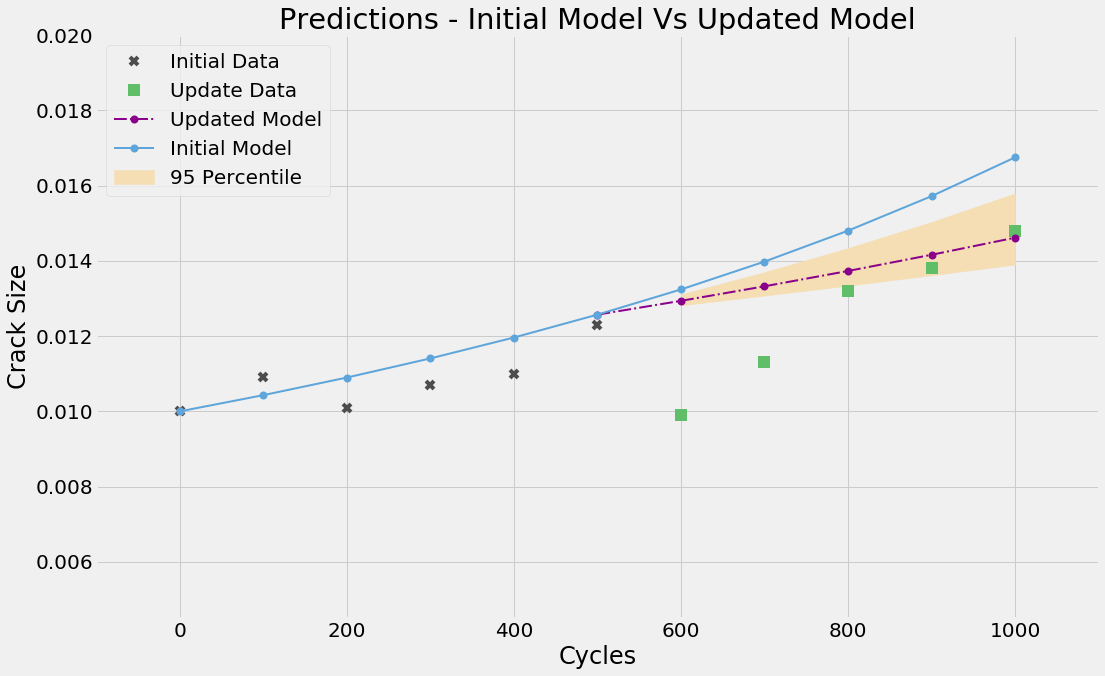

In [92]:
# Initial Model Prediction
fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(cycles[0:init_indx], crack_meas[0:init_indx], 'x', markersize=8, markeredgewidth=4, color=TFColor[8])
axs.plot(cycles[init_indx:updt_indx], crack_meas[init_indx:updt_indx], 's', markersize=8, markeredgewidth=4, color=TFColor[2])
axs.plot(cycles[init_indx-1:updt_indx], crack_pred_updt[0:init_indx], color=TFColor[9], linestyle='-.', marker='.', markersize=8,  markeredgewidth=4, linewidth=2)
axs.plot(cycles[0:updt_indx], crack_pred_init[0:updt_indx], color=TFColor[3], marker='.', linestyle='-', 
         markersize=8,  markeredgewidth=4, linewidth=2)
axs.fill_between(cycles[init_indx:updt_indx], crack_lower[1:init_indx], crack_upper[1:init_indx], color ='#F5DEB3')
plt.legend(['Initial Data', 'Update Data', 'Updated Model', 'Initial Model', '95 Percentile'], loc='upper left')
axs.set_xlabel('Cycles')
axs.set_ylabel('Crack Size')
axs.set_xlim([-100, 1100])
axs.set_ylim([0.0045, 0.02])
axs.grid(True)
plt.title('Predictions - Initial Model Vs Updated Model')
plt.savefig('Init_Vs_Updt_Model_1.png')

It can be observed from the plot above that the updated model predictions are more accurate when compared to the initial model. But, this is a rather expected and obvious result as we are plotting on the same data set that was used to update the model. The accuracy of the updated model can be gauged only if it's predictions are validated on a data set that wasn't used for the update. More importantly, the updated model should be more accurate, than the initial model, in predicting the future evolution of the crack. Otherwise, even the updated model is not particularly useful. 

The predictions (upto 1500 cycles) of the initial and the updated model are presented below 

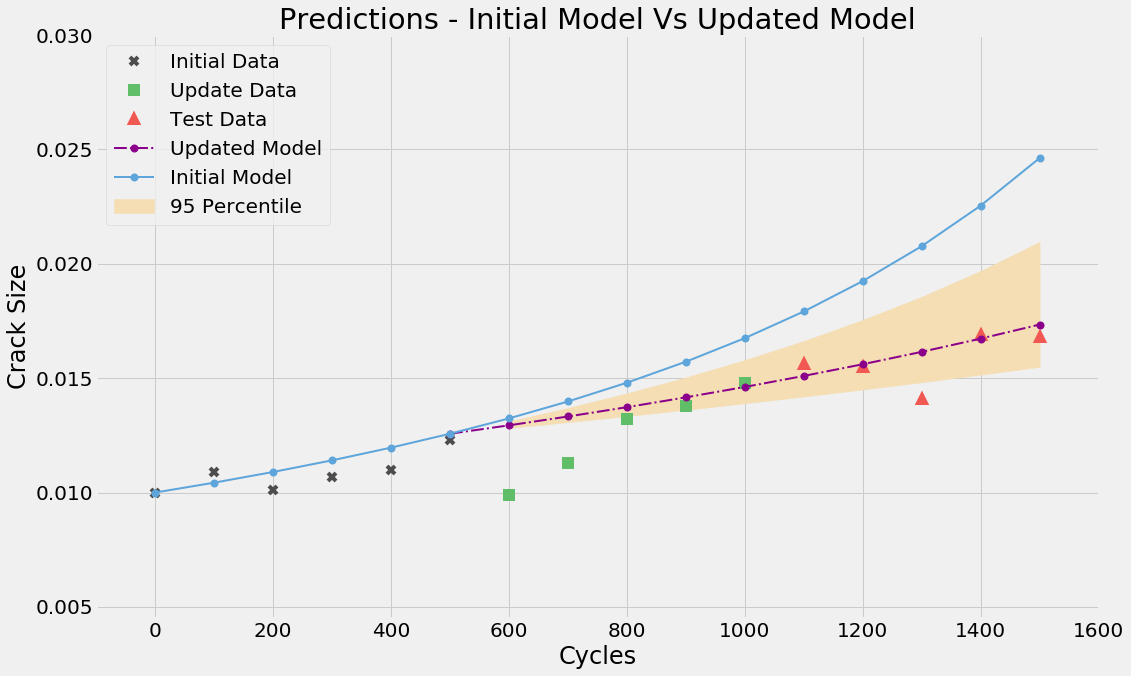

In [93]:
fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(cycles[0:init_indx], crack_meas[0:init_indx], 'x', markersize=8, markeredgewidth=4, color=TFColor[8])
axs.plot(cycles[init_indx:updt_indx], crack_meas[init_indx:updt_indx], 's', markersize=8, markeredgewidth=4, color=TFColor[2])
axs.plot(cycles[updt_indx:num_meas], crack_meas[updt_indx:num_meas], '^', markersize=8, markeredgewidth=4, color=TFColor[0])
axs.plot(cycles[init_indx-1:num_meas], crack_pred_updt, color=TFColor[9], linestyle='-.', marker='.', markersize=8,  markeredgewidth=4, linewidth=2)
axs.plot(cycles[0:num_meas], crack_pred_init[0:num_meas], color=TFColor[3], marker='.', linestyle='-', 
         markersize=8,  markeredgewidth=4, linewidth=2)
axs.fill_between(cycles[init_indx:num_meas], crack_lower[1:len(crack_lower)], crack_upper[1:len(crack_upper)], color ='#F5DEB3')
plt.legend(['Initial Data', 'Update Data', 'Test Data', 'Updated Model', 'Initial Model', '95 Percentile'], loc='upper left')
axs.set_xlabel('Cycles')
axs.set_ylabel('Crack Size')
axs.set_xlim([-100, 1600])
axs.set_ylim([0.0045, 0.03])
axs.grid(True)
plt.title('Predictions - Initial Model Vs Updated Model')
plt.savefig('Init_Vs_Updt_Model_2.png')

From the plot shown above, it is clear that the updated model is significantly more accurate in predicting the future evolution of the crack (from 1000 to 1500 cycles), when compared to the initial model. This suggests that UKF has been able to extract pertinent information from the measurements in the Update data set to modify the model parameters to make the model more accurate and useful. 

Another important thing to note here is the robustness of this approach to noisy measurements. In the Update data set, measurements corresponding to cycles 600 and 700 are outliers when compared to other measured values of crack. However, the impact of these outliers on the model update process is rather minimal as the UKF didn't try to minimize the error between the predictions and observations at these data points. This is a desirable outcome and such robustness to noisy measurements is critical for obtaining an accurate updated model.

The UKF based model update methodology not only estimates the mean of the model parameters, but also computes the covariance associated with the estimate. In other words, it provides the joint distribution of the state variables. This information can be used to infer the uncertainty associated with the predicted output, which in this case is the crack size.

The crack size forecast (upto 2200 cycles), along with the 95 percentile bounds, is plotted below

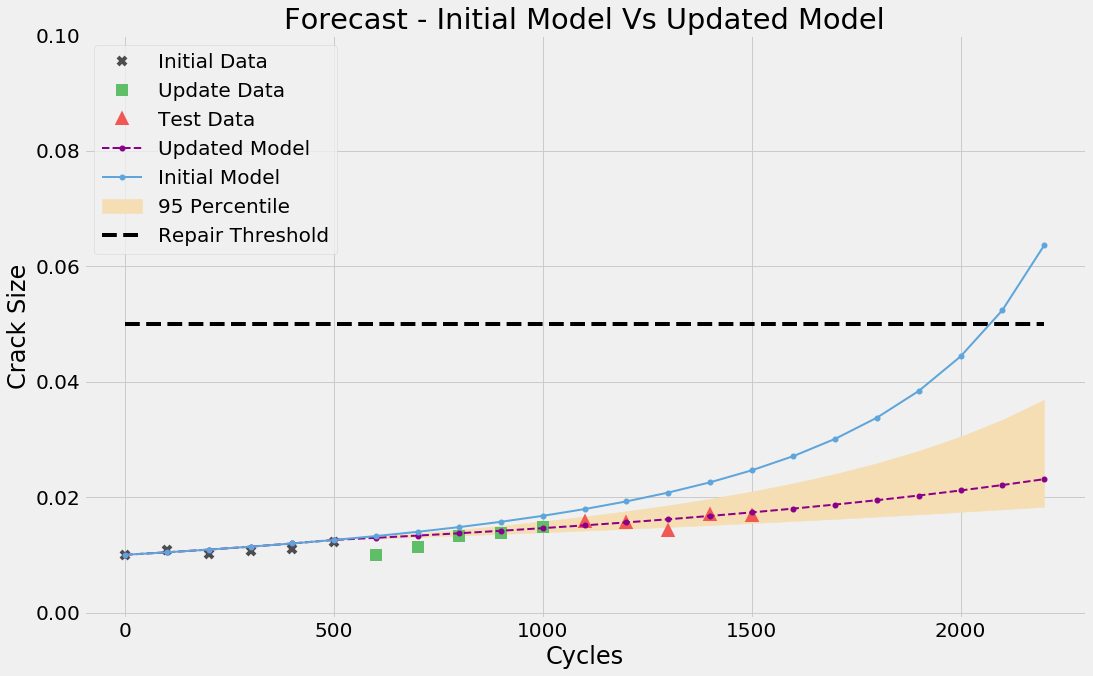

In [94]:
fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(cycles[0:init_indx], crack_meas[0:init_indx], 'x', markersize=8, markeredgewidth=4, color=TFColor[8])
axs.plot(cycles[init_indx:updt_indx], crack_meas[init_indx:updt_indx], 's', markersize=8, markeredgewidth=4, color=TFColor[2])
axs.plot(cycles[updt_indx:num_meas], crack_meas[updt_indx:num_meas], '^', markersize=8, markeredgewidth=4, color=TFColor[0])
axs.plot(newcycles, crack_forecast, color=TFColor[9], linestyle='--', marker='.', markersize=8,  markeredgewidth=2, linewidth=2)
axs.plot(newcycles, crack_forecast_init, color=TFColor[3], linestyle='-', marker='.', markersize=8,  markeredgewidth=2, linewidth=2)
axs.fill_between(newcycles[init_indx:len_], crack_low_forecast[1:len_], crack_up_forecast[1:len_], color ='#F5DEB3')
plt.hlines(0.05, np.min(newcycles), np.max(newcycles), linestyles = '--', label = 'threshold')
plt.legend(['Initial Data', 'Update Data', 'Test Data', 'Updated Model', 'Initial Model', '95 Percentile', 'Repair Threshold'], loc='upper left')
axs.set_xlabel('Cycles')
axs.set_ylabel('Crack Size')
axs.set_xlim([-100, 2300])
axs.set_ylim([-0.001, 0.1])
axs.grid(True)
plt.title('Forecast - Initial Model Vs Updated Model')
plt.savefig('Init_Vs_Updt_Model_3.png')

It is obvious from the chart above that the crack predictions would have been highly inaccurate if the initial model had not been updated with the measured data. In fact, a false alarm would have been generated at cycles = 2100 since the since the crack size predicted by the initial model is greater than the repair threshold, when the probability of such a crack occuring is actually significantly small (<< 5%).

## Summary
To conclude, the UKF based methodology for updating prognostic models is very useful in real-world applications where the data is limited and noisy. Further, it can accommodate non-linearities in the model. It is computationally efficient (almost the same as EKF) and some parts of the algorithm are parallelizable as well. The only restriction is the assumption of Gaussianity for the initial state. If this restriction is not acceptable to a particular problem, then an alternative would be the [Particle Filter](https://en.wikipedia.org/wiki/Particle_filter) at the cost of increased computational complexity. And in case, you got here still wondering why it is called the Unscented Kalman Filter, check [this](https://youtu.be/gFdT8W1fmf8) out.